# This notebook is a demonstration of running the combined peak ranging and peak ion identification ML models

Ryan Jacobs, based on original code from Jingrui Wei

Last updated: 5/5/25 by Ryan Jacobs


# Install and setup for Google Colab

In [1]:
# Link Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone repo

!git clone https://github.com/uw-cmg/peak_detection

Cloning into 'peak_detection'...
remote: Enumerating objects: 569, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 569 (delta 55), reused 32 (delta 11), pack-reused 449 (from 1)
Receiving objects: 100% (569/569), 57.10 MiB | 29.91 MiB/s, done.
Resolving deltas: 100% (301/301), done.


In [3]:
# Install dependencies. Annoyingly takes about 5 minutes.

!pip install -r "peak_detection/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of lmfit to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 850.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [1]:
# For Colab, move repo directories so imports work

import shutil
shutil.move('peak_detection', 'peak_detection_repo')
shutil.move('peak_detection_repo/peak_detection', '.')

'./peak_detection'

# Import needed packages

In [5]:
!pip install pymatgen
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymatgen 2025.5.2 requires numpy<3,>=1.25.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requi

In [16]:
import apav
import os
import peak_detection
from peak_detection.RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder
import yaml
from pathlib import Path
import torch.nn.functional as F
import joblib
import matplotlib.colors as mcolors
from pymatgen.core import Composition
import pandas as pd

# Function definitions to do model predictions and visualization

In [29]:
def map01(ar):
    return (ar-ar.min()) / (ar.max()-ar.min())

def load_apt(apt_file):
    '''

    '''
    # Load the .apt file and get histogram
    d = apav.load_apt(apt_file)
    x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False,)
    spectrum_log = torch.tensor(map01(np.log(spectrum+1)), dtype=torch.float32)
    return spectrum, spectrum_log

def sort_predictions(peak_range_pred, elements):
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    inds = list(peak_range_pred[:, 0].argsort())
    inds = [int(i) for i in inds]
    elements_sort = [elements[i] for i in inds]
    return peak_range_pred_sort, elements_sort

def get_label_encoder():
    '''

    '''

    CHEMICAL_ELEMENTS = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
                         'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
                         'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',
                         'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                         'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
                         'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir',
                         'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

    le = LabelEncoder()
    le.fit(CHEMICAL_ELEMENTS)
    return le

def get_RF_encoder():
    target_decoder = {0: 'Ag', 1: 'Al', 2: 'Ar', 3: 'As', 4: 'Au', 5: 'B', 6: 'Ba',
                      7: 'Be', 8: 'Bi', 9: 'Br', 10: 'C', 11: 'Ca', 12: 'Cd', 13: 'Ce',
                      14: 'Cl', 15: 'Co', 16: 'Cr', 17: 'Cs', 18: 'Cu', 19: 'Dy', 20: 'Er',
                      21: 'Eu', 22: 'F', 23: 'Fe', 24: 'Ga', 25: 'Gd', 26: 'Ge', 27: 'H',
                      28: 'He', 29: 'Hf', 30: 'Hg', 31: 'Ho', 32: 'I', 33: 'In', 34: 'Ir',
                      35: 'K', 36: 'Kr', 37: 'La', 38: 'Li', 39: 'Lu', 40: 'Mg', 41: 'Mn',
                      42: 'Mo', 43: 'N', 44: 'Na', 45: 'Nb', 46: 'Nd', 47: 'Ni', 48: 'O',
                      49: 'Os', 50: 'P', 51: 'Pb', 52: 'Pd', 53: 'Pr', 54: 'Pt', 55: 'Rb',
                      56: 'Re', 57: 'Rh', 58: 'Ru', 59: 'S', 60: 'Sb', 61: 'Sc', 62: 'Se',
                      63: 'Si', 64: 'Sm', 65: 'Sn', 66: 'Sr', 67: 'Ta', 68: 'Tb', 69: 'Te',
                      70: 'Th', 71: 'Ti', 72: 'Tl', 73: 'Tm', 74: 'U', 75: 'V', 76: 'W',
                      77: 'Xe', 78: 'Y', 79: 'Zn', 80: 'Zr'}
    return target_decoder

def predict_elements(model, spectrum, label_encoder, device):
    '''

    '''
    model.eval()
    with torch.no_grad():
        spectrum = torch.FloatTensor(spectrum).unsqueeze(0).to(device)
        outputs = model(spectrum, lengths = [spectrum.shape[1]])

        probabilities = F.softmax(outputs, dim=2)
        predictions = torch.argmax(outputs, dim=2)

        # Convert numerical predictions to element names
        element_predictions = label_encoder.inverse_transform(predictions.cpu().numpy().ravel())
        confidence_scores = torch.max(probabilities, dim=2)[0].cpu().numpy().ravel()

        return element_predictions, confidence_scores

def plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000, resort=True, res2=None, confidence2=None):
    '''
    plot_max : # in 0.01 Da
    '''
    plt.clf()
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # set the zoom in m/c range
    bin_width = 0.01
    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] >plot_min)]

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Plot the spectrum
    x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

    ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)

    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    for start, end in peak_pred_:
        ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
    for start, end in peak_pred_:
        ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
        ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)

    # Set labels and title
    ax.set_xlabel('Mass to charge ratio (Da)')
    ax.set_ylabel('Intensity in log scale normalized (counts)')

    ax.set_xlim(-2, 0.01*plot_max)

    # Add the predicted ions and their confidences
    if resort == True:
        peak_range_pred = peak_range_pred[peak_range_pred[:, 0].argsort()][:, 0]
    else:
        peak_range_pred = peak_range_pred[:, 0]
    #for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
    if res2 is not None:
        for peak_start, ion, conf, ion2, conf2 in zip(peak_range_pred, res, confidence, res2, confidence2):
            if peak_start < plot_max:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                if conf2 > 0.0:
                    ax.text(0.01*float(peak_start)+0.02, y_rand-0.05, ion2+':'+str(round(conf2,2)), color='blue')
    else:
        for peak_start, ion, conf in zip(peak_range_pred, res, confidence):
            if peak_start < plot_max:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    plt.legend()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def predict_peak_ranges(apt_file, conf=0.02, iou=0.01, max_det=2000):
    '''

    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # Load in the RangingNN model and do the peak detection
    cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
    cfg = yaml.safe_load(Path(cfg).read_text())

    cfg['iou'] = iou
    cfg['conf'] = conf
    cfg['max_det'] = max_det

    modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights/best.pt') # loading the default trained-model in the package
    predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = 'test_results', cfg = cfg)
    result = predictor()[0]
    peak_range_pred = result[:,:2].cpu()
    counts = result[:,2].cpu()

    print('model predicted peaks:',peak_range_pred.shape[0])

    return peak_range_pred, counts

def predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5):
    '''
    Certain wide ranges due to the tail leads to over-high indensity,
    shrinking the other intensities, so set limit here
    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    profile = np.zeros_like(peak_range_pred)
    peak_range_pred = np.asarray(peak_range_pred)

    # Preprocess detected peak ranging data for IonClassifier model
    for k in range(profile.shape[0]):
        profile[k][0] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][1])+1].argmax()
        profile[k][0] = (profile[k][0] + round(peak_range_pred[k][0]))/100

        window = min(max_width_Da/bin_width, round(peak_range_pred[k][1])+1-round(peak_range_pred[k][0]))
        profile[k][1] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][0]+window)].sum()

    profile[:,1] = (profile[:,1] - profile[:,1].min() ) / (profile[:,1].max() - profile[:,1].min()) # normalize counts from one spectrum to 0-1

    # Make sure the profile is in sequential order, increasing m/c
    profile_final = profile[profile[:, 0].argsort()]

    # Run the IonClassifier model to predict the peak IDs
    model_path = os.path.join(os.path.dirname(peak_detection.__file__), 'Ionclassifier/modelweights')
    RNNmodel = torch.load(os.path.join(model_path, 'model_bestepoch.tar'), map_location='cpu')['ema']
    le = get_label_encoder()
    res, confidence = predict_elements(RNNmodel, profile_final, le, 'cpu')

    return res, confidence, profile_final

def predict_peak_ions_RF(peak_range_pred, counts):
    '''
    Use in-development Random forest model for ion peak IDs
    '''

    scaler_path = 'peak_detection_extra/randomforest/StandardScaler.pkl'
    model_path = 'peak_detection_extra/randomforest/RandomForestClassifier.pkl'

    scaler = joblib.load(scaler_path)
    model = joblib.load(model_path)

    X_0 = 0.01*peak_range_pred[:, 0]
    X_1 = counts
    X = np.column_stack((X_0, X_1))
    X_norm = scaler.transform(X)

    preds = model.predict_proba(X_norm)

    target_decoder = get_RF_encoder()

    elements = list()
    second_elements = list()
    confs = list()
    second_confs = list()
    for pred in preds:
        element = target_decoder[pred.argsort()[-1]]
        conf = pred[pred.argsort()[-1]]
        elements.append(element)
        confs.append(conf)

        second_element = target_decoder[pred.argsort()[-2]]
        second_conf = pred[pred.argsort()[-2]]
        if second_conf > 0.0:
          second_elements.append(second_element)
        else:
          second_elements.append('NaN')
        second_confs.append(second_conf)

    return elements, second_elements, confs, second_confs

def plot_predictions_NEW(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000, resort=True, res2=None, confidence2=None):
    '''
    plot_max : # in 0.01 Da
    '''
    colors = list(mcolors.TABLEAU_COLORS.values())
    color_inds = [int(np.random.uniform(0, len(colors))) for _ in range(peak_range_pred.shape[0])]

    plt.clf()
    plt.figure(figsize=(10, 6))
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    x = np.linspace(0.0, spectrum_log.shape[0]*0.01, spectrum_log.shape[0])
    plt.plot(x, spectrum_log)

    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] > plot_min)]

    count = 0
    for start, end in peak_pred_:
        plt.axvspan(start*0.01, end*0.01, alpha=0.3, color=colors[color_inds[count]])
        plt.axvline(start*0.01, color=colors[color_inds[count]], linestyle='--', alpha=0.7, lw = 0.7)
        plt.axvline(end*0.01, color=colors[color_inds[count]], linestyle='--', alpha=0.7, lw = 0.7)
        count += 1

    # Set labels and title
    plt.xlabel('Mass to charge ratio (Da)')
    plt.ylabel('Intensity in log scale normalized (counts)')

    plt.xlim(0.01*plot_min, 0.01*plot_max)

    # Add the predicted ions and their confidences
    if resort == True:
        peak_range_pred = peak_range_pred[peak_range_pred[:, 0].argsort()][:, 0]
    else:
        peak_range_pred = peak_range_pred[:, 0]
    #for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
    if res2 is not None:
        for peak_start, ion, conf, ion2, conf2 in zip(peak_range_pred, res, confidence, res2, confidence2):
            if peak_start < plot_max and peak_start > plot_min:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                plt.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                if conf2 > 0.0:
                    plt.text(0.01*float(peak_start)+0.02, y_rand-0.05, ion2+':'+str(round(conf2,2)), color='blue')
                    #plt.text(0.01*float(peak_start)+0.02, 1.0, ion2+':'+str(round(conf2,2)), color='blue')
    else:
        for peak_start, ion, conf in zip(peak_range_pred, res, confidence):
            if peak_start < plot_max and peak_start > plot_min:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                plt.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                #plt.text(0.01*float(peak_start)+0.02, 1.05, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def calculate_iou_1d(interval1, interval2):
    """
    Calculates the Intersection over Union (IoU) of two 1D intervals.

    Args:
        interval1: A tuple or list of two numbers representing the start and end of the first interval.
        interval2: A tuple or list of two numbers representing the start and end of the second interval.

    Returns:
        The IoU of the two intervals, a float between 0 and 1.
    """

    start1, end1 = interval1
    start2, end2 = interval2

    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)

    intersection_length = max(0, intersection_end - intersection_start)

    union_length = (end1 - start1) + (end2 - start2) - intersection_length

    if union_length == 0:
        return 0.0

    iou = intersection_length / union_length
    return iou

def evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2):
    multiplier = 0.01
    iou_thresh = 0.1
    num_found = 0
    num_true = len(rng)
    num_pred = peak_range_pred_sort.shape[0]
    true_elements = list()
    pred_elements = list()
    pred_elements2 = list()
    is_found = list()
    true_found_elements = list()
    true_start = list()
    true_end = list()
    for _, i in enumerate(rng):
        start = i.lower
        end = i.upper
        ious = list()
        true_start.append(start)
        true_end.append(end)
        for __, j in enumerate(peak_range_pred_sort):
            iou = calculate_iou_1d((start, end), (multiplier*float(j[0]), multiplier*float(j[1])))
            ious.append(iou)
        # Find the index with max iou
        iou_max_ind = np.where(np.array(ious)==max(np.array(ious)))[0][0]
        max_iou = ious[iou_max_ind]
        if max_iou >= iou_thresh:
            #print('Found peak', i, 'with true ion', i.hill_formula, 'and predicted ion', elements_sort[iou_max_ind], 'or', elements_sort2[iou_max_ind])
            num_found += 1
            is_found.append(True)
            true_found_elements.append(i.hill_formula)
            true_elements.append(i.hill_formula)
            pred_elements.append(elements_sort[iou_max_ind])
            if elements_sort2 is not None:
                pred_elements2.append(elements_sort2[iou_max_ind])
            else:
                pred_elements2.append(None)
        else:
            is_found.append(False)
            true_found_elements.append('NaN')
            #print('No peak found for', i)

    # These are statistics of finding peaks in the right place (i.e., ranging)
    #print(num_true, num_pred, num_found)
    prec = num_found/num_pred
    recall = num_found/num_true
    f1 = 2*prec*recall/(prec+recall)
    #print(prec, recall, f1)

    # Of the peaks that are found in the right positions, quantify the ion classification accuracy
    num_correct = 0
    num_found_molecule = num_found
    for true, pred, pred2 in zip(true_elements, pred_elements, pred_elements2):
        true = Composition(true).reduced_formula
        pred = Composition(pred).reduced_formula
        pred2 = Composition(pred2).reduced_formula
        #print(true, pred, pred2)
        # for molecules, just consider one of the host elements as being correct for now
        if true == pred or true == pred2:
            num_correct += 1
            #print('found match', true, pred, pred2)
        # Remove the molecules for now
        elif len(true) > 2 or '2' in true or '3' in true or '4' in true:
            num_found_molecule -= 1
            #print('found molecule to ignore', true, pred)
        else:
            #print('No match for', true, pred, pred2)
            pass

    acc = num_correct/num_found
    acc_nomol = num_correct/num_found_molecule
    #print(acc)

    return prec, recall, f1, acc, acc_nomol, is_found, true_found_elements, true_start, true_end

# Run the peak detection and NN ion classifier together

INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  389.2ms inference, 22.1ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


<Figure size 640x480 with 0 Axes>

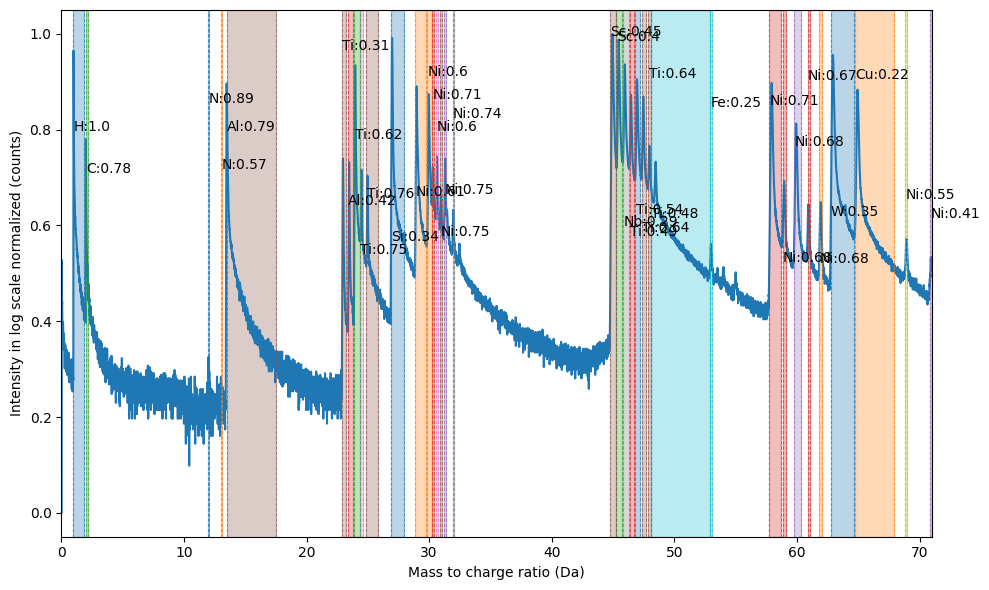

In [38]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results. This block uses Jingrui's NN model

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

res, confidence, profile_final = predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5)

#plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=2000, resort=True)

plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred,
                 res=res,
                 confidence=confidence,
                 plot_min=0,
                 plot_max=7100,
                 resort=True)


# Run the peak detection and RF ion classifier together

In [5]:
# Need to git clone peak_detection_extra to get large RF model file
!git clone https://github.com/uw-cmg/peak_detection_extra

Cloning into 'peak_detection_extra'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
Receiving objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0 (from 0)


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  97.1ms inference, 5.0ms postprocess for per spectrum 
model predicted peaks: 36


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


<Figure size 640x480 with 0 Axes>

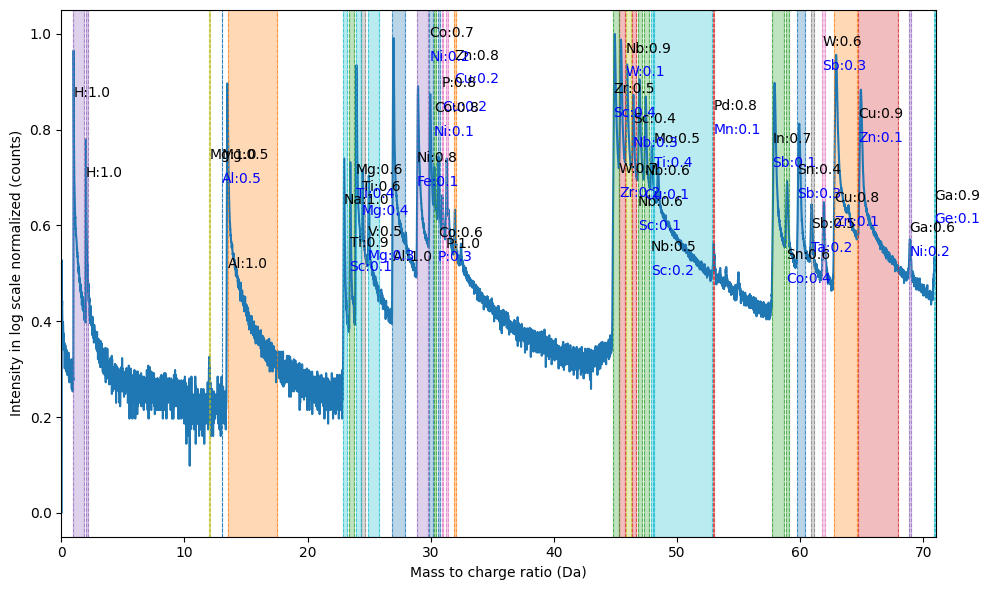

In [37]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results. This block uses in-development Random forest model

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred, counts)

plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred,
                 res=elements,
                 confidence=confs,
                 plot_min=0,
                 plot_max=7100,
                 resort=False,
                 res2=second_elements,
                 confidence2=second_confs)

# Run evaluation over all files for both models


In [39]:

apt_files = ['drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt',
              'drive/MyDrive/Cameca/data_from_David/R15_72243.apt',
             'drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt',
              'drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt',
              'drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt']

rrng_files = ['drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG',
              'drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG',
              'drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG',
              'drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG',
              'drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG']

for apt_file, rrng in zip(apt_files, rrng_files):
    results = dict()
    print('**************************')
    print('ANALYZIG FILE', apt_file, rrng)
    print('**************************')
    rng = apav.load_rrng(rrng)

    # Get peak ranges
    peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

    # Do Jingrui NN classification
    elements_sort, confidence, profile_final = predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5)

    # Sort preds. For NN, the elements are already sorted
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    #peak_range_pred_sort, elements_sort = sort_predictions(peak_range_pred, res)
    elements_sort2 = ['NaN' for i in elements_sort]

    # Evaluate preds
    prec, recall, f1, acc_NN, acc_NN_nomol, is_found, true_found_elements, true_start, true_end = evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2)

    print('Peak finding results')
    print(prec, recall, f1)

    results['Peak range true value, start'] = true_start
    results['Peak range true value, end'] = true_end
    results['Peak found?'] = is_found
    results['True ions found'] = true_found_elements

    results['Peak find precision'] = [prec]
    results['Peak find recall'] = [recall]
    results['Peak find F1'] = [f1]

    results['Peak range prediction, start'] = peak_range_pred_sort[:,0]
    results['Peak range prediction, end'] = peak_range_pred_sort[:,1]
    results['Peak range prediction, counts'] = counts
    results['Ion classification (Jingrui NN)'] = elements_sort
    results['Ion classification confidence (Jingrui NN)'] = confidence

    results['Ion classification accuracy (Jingrui NN)'] = [acc_NN]
    results['Ion classification accuracy without molecules (Jingrui NN)'] = [acc_NN_nomol]

    # Do RF classification
    elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred, counts)

    # Sort preds
    peak_range_pred_sort, elements_sort = sort_predictions(peak_range_pred, elements)
    peak_range_pred_sort, elements_sort2 = sort_predictions(peak_range_pred, second_elements)

    # Evaluate preds
    prec, recall, f1, acc_RF, acc_RF_nomol, is_found, true_found_elements, true_start, true_end = evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2)

    results['Ion classification (Random forest)'] = elements_sort
    results['Ion classification confidence (Random forest)'] = confs
    results['Ion classification 2nd choice (Random forest)'] = elements_sort2
    results['Ion classification 2nd choice confidence (Random forest)'] = second_confs
    results['Ion classification accuracy (Random forest)'] = [acc_RF]
    results['Ion classification accuracy without molecules (Random forest)'] = [acc_RF_nomol]

    print('Jingrui NN Ion classification results')
    print(acc_NN, acc_NN_nomol)

    print('Random Forest Ion classification results')
    print(acc_RF, acc_RF_nomol)

    results_df = pd.DataFrame().from_dict(results, orient='index').T
    results_df.to_csv(apt_file.split('/')[-1]+'_results.csv', index=False)



INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


**************************
ANALYZIG FILE drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG
**************************
Start inference
Speed:  175.1ms inference, 11.7ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36
Peak finding results
0.9166666666666666 0.9705882352941176 0.9428571428571428


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R15_72243.apt


Jingrui NN Ion classification results
0.3939393939393939 0.4482758620689655
Random Forest Ion classification results
0.42424242424242425 0.4666666666666667
**************************
ANALYZIG FILE drive/MyDrive/Cameca/data_from_David/R15_72243.apt drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG
**************************
Start inference
Speed:  237.7ms inference, 10.6ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R15_72243.apt


model predicted peaks: 16
Peak finding results
0.9375 0.8823529411764706 0.9090909090909091


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt


Jingrui NN Ion classification results
0.2 0.21428571428571427
Random Forest Ion classification results
0.7333333333333333 0.7333333333333333
**************************
ANALYZIG FILE drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG
**************************
Start inference
Speed:  123.0ms inference, 7.1ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt


model predicted peaks: 58
Peak finding results
0.9655172413793104 0.9655172413793104 0.9655172413793104


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt


Jingrui NN Ion classification results
0.19642857142857142 0.25
Random Forest Ion classification results
0.625 0.7777777777777778
**************************
ANALYZIG FILE drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG
**************************
Start inference
Speed:  172.2ms inference, 3.5ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt


model predicted peaks: 8
Peak finding results
0.625 1.0 0.7692307692307693


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt


Jingrui NN Ion classification results
0.2 0.3333333333333333
Random Forest Ion classification results
0.4 0.6666666666666666
**************************
ANALYZIG FILE drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG
**************************
Start inference
Speed:  105.2ms inference, 9.1ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt


model predicted peaks: 75
Peak finding results
0.6666666666666666 0.819672131147541 0.7352941176470588


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Jingrui NN Ion classification results
0.2 0.6666666666666666
Random Forest Ion classification results
0.22 0.6470588235294118
